# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import numpy as np
import random
from collections import namedtuple,deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
#model
class QNetWork(nn.Module):
    """
    transform a state to action value
    """
    def __init__(self,state_size,action_size,hidden_layers=[512,256]):
        """
        state_size: the size of state space
        action_size: the dimenson
        hidden_layers: a list of nodes
        """
        super(QNetWork,self).__init__()
        node_list = [state_size] + hidden_layers + [action_size]
        self.layers = nn.ModuleList([nn.Linear(node_list[i],node_list[i+1]) for i in range(len(node_list)-1)])
    
    def forward(self,x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers)-1:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x

In [8]:
class ReplayPool:
    """
    Fixed-size buffer to store experience tuples
    """
    def __init__(self,buffer_size,batch_size,device='cpu'):
        """
        action_size: size of action space
        buffer_size: maximum size of buffer
        batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",field_names=["state","action","reward","next_state","done"])
        self.device = device
        
    def add(self,state,action,reward,next_state,done):
        """
        add a new experience to memory
        """
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
    
    def sample(self):
        """
        Randomly sample a batch of experiences from memory.
        """
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    
    def __len__(self):
        """
        return the current size of internal memory
        """
        return len(self.memory)
        

In [9]:
class Agent():
    """
    interact with the environment 
    """
    def __init__(self,state_size,
                 action_size,
                 replay_pool_size=int(1e5),
                 batch_size=64,
                 gamma=0.99,
                 update_step=4,
                 lr=5e-4,
                 tau=1e-3,
                 device='cpu'):
        """
        state_size: the size of state space
        action_size: the size of actoin space
        replay_pool_size: the size of replay size need to store
        batch_size: the size of minibatch used in learning
        gamma:discount rate
        update_step: how often to update target network
        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.device = device
        
        #QNetWork
        self.qnetwork_local = QNetWork(state_size,action_size).to(self.device)
        self.qnetwork_target = QNetWork(state_size,action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=lr)
        
        #create replay pool
        self.memory = ReplayPool(replay_pool_size,batch_size,device=self.device)
        
        self.t_step = 0
        self.update_step = update_step
        
    def step(self,state,action,reward,next_state,done):
        #put the experience into the pool
        self.memory.add(state,action,reward,next_state,done)
        
        #learn every update_step
        self.t_step = (self.t_step + 1)%self.update_step
        if self.t_step ==0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
    
    def act(self,state,eps=0.):
        """
        return actions for given state as per current policy
        state : current state
        eps: epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            actio_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        #epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(actio_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self,experiences):
        """
        update the qnetwork local
        experiences: tuple of (s,a,r,s',done) tuples
        gamma (float): discount factor
        """
        states,actions,rewards,next_states,dones = experiences
        
        self.optimizer.zero_grad()
        q_local = self.qnetwork_local.forward(states).gather(1,actions)
        q_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_target = rewards+self.gamma*q_next*(1-dones)
        loss = F.mse_loss(q_target,q_local)
        loss.backward()
        self.optimizer.step()
        
        #soft update of target network
        self.soft_update()
        
    def soft_update(self):
        """
        weight_target = tau*weight_local+(1-tau)*weight_target
        """
        for target_param, local_param in zip(self.qnetwork_target.parameters(),self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data+(1-self.tau)*target_param.data)      

In [10]:
#training
def train_network(agent,n_episodes=1500,max_t=10000,eps_start=1,eps_end=0.01,eps_decay=0.995):
    """
    n_episodes: maximum number of training episodes
    max_t: maximum number of timesteps per episode
    eps_start: start of epsilon
    eps_end: minimum value of epsilon
    eps_decay: decay factor for epsilon
    """
    scores = []
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score+=reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end,eps_decay*eps)
        
        if i_episode % 100 ==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(),'checkpoint.pth')
            
    return scores
        

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = Agent(action_size=action_size,state_size=state_size,device=device)


In [12]:
scores = train_network(agent)

Episode 100	Average Score: 1.05
Episode 200	Average Score: 3.84
Episode 300	Average Score: 6.34
Episode 400	Average Score: 8.73
Episode 500	Average Score: 12.81
Episode 600	Average Score: 13.83
Episode 700	Average Score: 14.08
Episode 800	Average Score: 13.29
Episode 900	Average Score: 13.03
Episode 1000	Average Score: 14.61
Episode 1100	Average Score: 14.87
Episode 1200	Average Score: 14.83
Episode 1300	Average Score: 15.06
Episode 1400	Average Score: 14.19
Episode 1500	Average Score: 14.33


In [13]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Episode #')

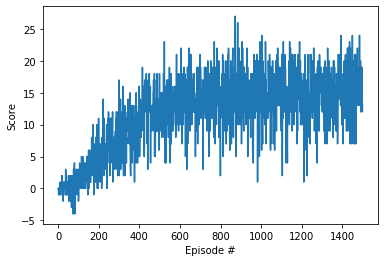

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

In [17]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state,0.01)                 # select an action
    env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 21.0
